Intention of this notebook is to cluster the sequence representations (extractions from deep CNN) using t-SNE and see wheter the cluster more according to source protein ID or more towards temperature change.

## Notebook Setup

In [0]:
#Imports:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import pickle

import numpy as np
from sklearn.manifold import TSNE

import seaborn as sns 
sns.set()
import matplotlib.pyplot as plt

In [0]:
#Connect to google drive:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#Set up file paths:
data_folder_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/T1626/cnn_rep_sampler_T1626/"
base_data_folder_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/T1626/own_baseline_xgboost_T1626/"
model_folder_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Validation/Clustering_Sequence_Representation/"

y_target_loc = base_data_folder_loc + "y_label_own_baseline_xgboost_T1626.pkl"
X_seq_all_01_loc =  data_folder_loc + "sequence_cnn_rep_all_default_01.csv"
X_seq_diff_01_loc =  data_folder_loc + "sequence_cnn_rep_diff_default_01.csv"
X_seq_all_02_loc =  data_folder_loc + "sequence_cnn_rep_all_default_02.csv"
X_seq_diff_02_loc =  data_folder_loc + "sequence_cnn_rep_diff_default_02.csv"
X_seq_all_03_loc =  data_folder_loc + "sequence_cnn_rep_all_default_03.csv"
X_seq_diff_03_loc =  data_folder_loc + "sequence_cnn_rep_diff_default_03.csv"
X_seq_all_64_loc =  data_folder_loc + "sequence_cnn_rep_all_64_01.csv"
X_seq_diff_64_loc =  data_folder_loc + "sequence_cnn_rep_diff_64_01.csv"

mutation_table_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/T1626/sequence_sampler_T1626/"+"T1626_sequences_only.csv"
fig_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Validation/Clustering_Sequence_Representation/"

print("Folders: ")
print("\t",os.path.isdir(data_folder_loc))
print("\t",os.path.isdir(base_data_folder_loc))
print("\t",os.path.isdir(model_folder_loc))
print("\t",os.path.isdir(fig_loc))
print("Files: ")
print("\t",os.path.isfile(y_target_loc))
print("\t",os.path.isfile(X_seq_all_01_loc))
print("\t",os.path.isfile(X_seq_diff_01_loc))
print("\t",os.path.isfile(X_seq_all_02_loc))
print("\t",os.path.isfile(X_seq_diff_02_loc))
print("\t",os.path.isfile(X_seq_all_03_loc))
print("\t",os.path.isfile(X_seq_diff_03_loc))
print("\t",os.path.isfile(X_seq_all_64_loc))
print("\t",os.path.isfile(X_seq_diff_64_loc))
print("\t",os.path.isfile(mutation_table_loc))

Folders: 
	 True
	 True
	 True
	 True
Files: 
	 True
	 True
	 True
	 True
	 True
	 True
	 True
	 True
	 True
	 True


## Prepare Data

In [0]:
#Just load data
y_label = pd.read_pickle(y_target_loc) 
mutation_table = pd.read_csv(mutation_table_loc, index_col=0)

X_seq_all_01 = pd.read_csv(X_seq_all_01_loc, index_col=0)
X_seq_diff_01 = pd.read_csv(X_seq_diff_01_loc, index_col=0)
X_seq_all_02 = pd.read_csv(X_seq_all_02_loc, index_col=0)
X_seq_diff_02 = pd.read_csv(X_seq_diff_02_loc, index_col=0)
X_seq_all_03 = pd.read_csv(X_seq_all_03_loc, index_col=0)
X_seq_diff_03 = pd.read_csv(X_seq_diff_03_loc, index_col=0)
X_seq_all_64 = pd.read_csv(X_seq_all_64_loc, index_col=0)
X_seq_diff_64 = pd.read_csv(X_seq_diff_64_loc, index_col=0)

In [0]:
y_dtm_type = y_label>0 #whether the mutation is stabalizing or not
y_protein = list(map(lambda x: x.strip().split("@")[0].split("_")[0], mutation_table["Mutation"].values))

In [0]:
print(y_protein[:10])

['1AKY', '1AKY', '1AKY', '1AKY', '1AKY', '1AKY', '1AM7', '1ANK', '1ANK', '1ANK']


In [0]:
X_seq_all_01_02_03 = pd.concat([X_seq_all_01, X_seq_all_02, X_seq_all_03], axis=1)
X_seq_diff_01_02_03 = pd.concat([X_seq_diff_01, X_seq_diff_02, X_seq_diff_03], axis=1)
X_seq_all_01_02_03 = X_seq_all_01_02_03.reset_index(drop=True)
X_seq_diff_01_02_03 = X_seq_diff_01_02_03.reset_index(drop=True)

In [0]:
X_seq_all_01_02_03.head()

,wt_rep_0,wt_rep_1,wt_rep_2,wt_rep_3,wt_rep_4,wt_rep_5,wt_rep_6,wt_rep_7,wt_rep_8,wt_rep_9,wt_rep_10,wt_rep_11,wt_rep_12,wt_rep_13,wt_rep_14,wt_rep_15,wt_rep_16,wt_rep_17,wt_rep_18,wt_rep_19,wt_rep_20,wt_rep_21,wt_rep_22,wt_rep_23,wt_rep_24,wt_rep_25,wt_rep_26,wt_rep_27,wt_rep_28,wt_rep_29,wt_rep_30,wt_rep_31,wt_rep_32,wt_rep_33,wt_rep_34,wt_rep_35,wt_rep_36,wt_rep_37,wt_rep_38,wt_rep_39,...,diff_rep_728,diff_rep_729,diff_rep_730,diff_rep_731,diff_rep_732,diff_rep_733,diff_rep_734,diff_rep_735,diff_rep_736,diff_rep_737,diff_rep_738,diff_rep_739,diff_rep_740,diff_rep_741,diff_rep_742,diff_rep_743,diff_rep_744,diff_rep_745,diff_rep_746,diff_rep_747,diff_rep_748,diff_rep_749,diff_rep_750,diff_rep_751,diff_rep_752,diff_rep_753,diff_rep_754,diff_rep_755,diff_rep_756,diff_rep_757,diff_rep_758,diff_rep_759,diff_rep_760,diff_rep_761,diff_rep_762,diff_rep_763,diff_rep_764,diff_rep_765,diff_rep_766,diff_rep_767
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,-0.063452,0.000000,0.000000,0.345296,0.000000,0.000000,0.000000,0.000000,-0.051311,0.000000,0.000000,0.000000,0.000000,-0.163934,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.001523,0.000000,-0.001606,0.000000,-0.277752,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.042222,0.000000,-0.206137,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.135772,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.012303,0.336062,0.000000,0.000000,0.000000,0.000000,0.001812,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.063004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,-0.001237,0.000000,0.000000,0.000000,0.000000,0.000000,-0.025286,0.000000,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,-0.572438,0.063372,0.000000,-0.341408,0.053894,0.348088,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.420903,0.000000,0.0,0.103690,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.098217,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040153,0.114376,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.261823,0.078858,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.124731,-0.011780,-0.003999,0.136516,0.000000,-0.201293,0.000000,-0.153837,0.0,-0.022995,-0.007815,0.000000,0.000000,0.000000,0.066218,0.000000,-0.154907,0.000000,-0.01932,0.000000,0.000000,0.068523,-0.103127,0.009915,0.000000,0.000000,0.000000,0.000000,0.040680
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,-0.036989,0.000000,0.000000,0.000000,0.065008,0.000000,0.000000,0.000000,0.057740,-0.010517,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.172975,0.000000,0.074728,0.000000,-0.223700,0.000000,0.039526,0.000000,0.00000,0.000000,0.011059,0.000000,0.000000,-0.080509,0.000000,0.000000,0.239078,0.000000,0.303034


In [0]:
print(X_seq_all_01_02_03.shape)

(1626, 5376)


## Perform Clustering using t-SNE

In [0]:
X_embedded = TSNE(n_components=2).fit_transform(X_seq_all_01_02_03)
X_embedded.shape

(1626, 2)

In [0]:
X_embedded_df = pd.DataFrame(X_embedded)
X_embedded_df["dTm"] = list(map(lambda x: "positive" if x else "negative", y_dtm_type))
X_embedded_df["wildtype protein"] = y_protein
X_embedded_df.columns = ["Feature_01","Feature_02","dTm","wildtype protein"]
X_embedded_df.head()

,Feature_01,Feature_02,dTm,wildtype protein
0,-21.913383,13.438442,negative,1AKY
1,-21.912159,13.440067,negative,1AKY
2,-21.917332,13.440437,negative,1AKY
3,-21.914789,13.436631,negative,1AKY
4,-21.912798,13.435467,negative,1AKY


In [0]:
X_embedded_df.columns

Index(['Feature_01', 'Feature_02', 'dTm', 'wildtype protein'], dtype='object')

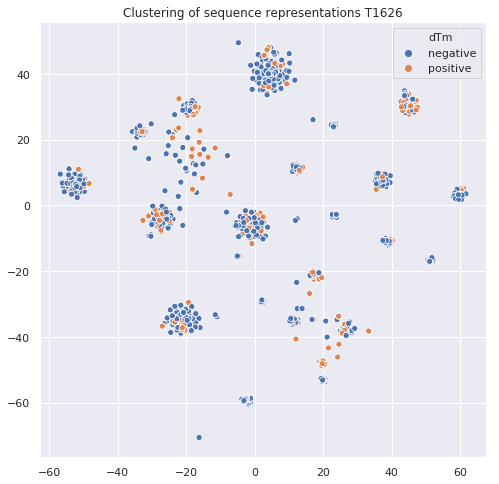

In [0]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x="Feature_01", y="Feature_02", hue="dTm", data=X_embedded_df, ax=ax).set_title("Clustering of sequence representations T1626")
ax.set_ylabel('')    
ax.set_xlabel('')
plt.savefig(fig_loc+"clustering_all_dTm.png", dpi=300)
plt.show()

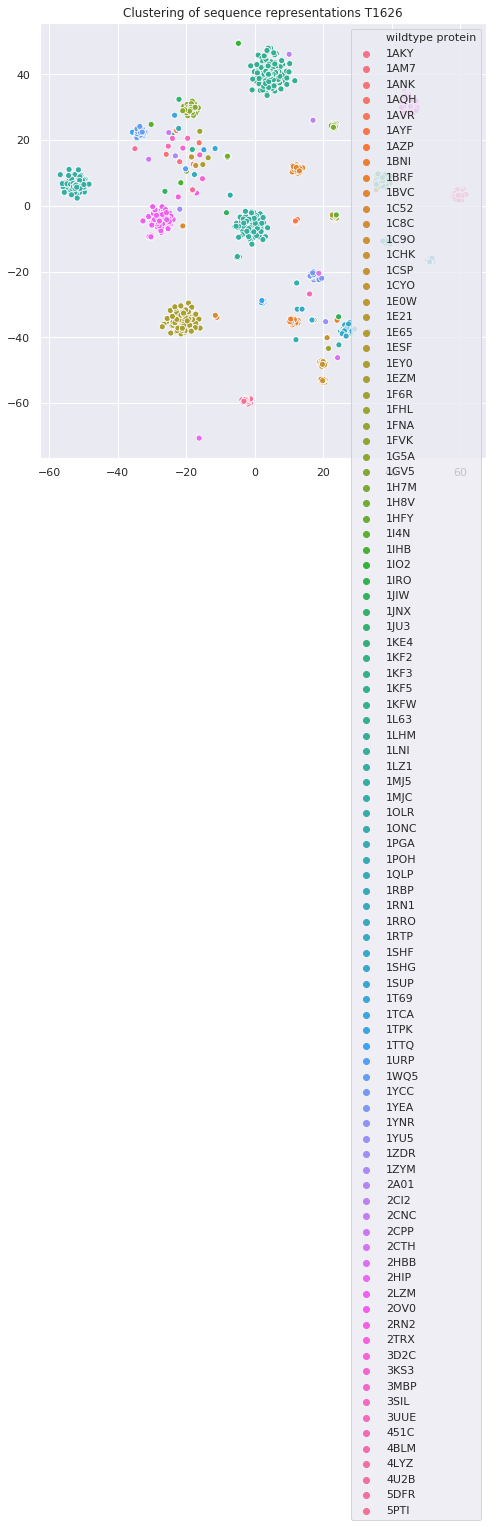

In [0]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x="Feature_01", y="Feature_02", hue="wildtype protein", data=X_embedded_df, ax=ax).set_title("Clustering of sequence representations T1626")
ax.set_ylabel('')    
ax.set_xlabel('')
plt.savefig(fig_loc+"clustering_all_protein.png", dpi=300)
plt.show()

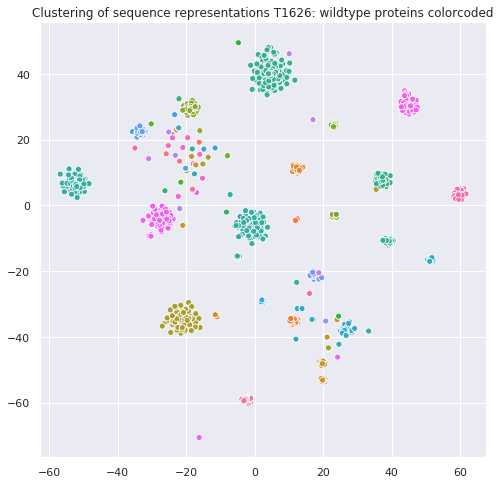

In [0]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x="Feature_01", y="Feature_02", hue="wildtype protein", data=X_embedded_df, ax=ax).set_title("Clustering of sequence representations T1626: wildtype proteins colorcoded")
ax.set_ylabel('')    
ax.set_xlabel('')
ax.legend().set_visible(False)
plt.savefig(fig_loc+"clustering_all_protein_no_legend.png", dpi=300)
plt.show()

In [0]:
protein_filter = pd.Series(y_protein)=="1L63"
X_embedded_single = TSNE(n_components=2).fit_transform(X_seq_all_01_02_03[protein_filter])
X_embedded_single.shape

(184, 2)

In [0]:
X_embedded_single_df = pd.DataFrame(X_embedded_single)
X_embedded_single_df["dTm"] = list(map(lambda x: "positive" if x else "negative", pd.Series(y_dtm_type)[protein_filter].values))
X_embedded_single_df["wt_protein"] = pd.Series(y_protein)[protein_filter].values
X_embedded_single_df.columns = ["Feature_01","Feature_02","dTm","wt_protein"]
X_embedded_single_df.head()

,Feature_01,Feature_02,dTm,wt_protein
0,-8.592758,-6.616593,negative,1L63
1,-8.618640,-6.639868,negative,1L63
2,-8.070075,-6.190845,negative,1L63
3,-8.842109,-6.833439,negative,1L63
4,3.633042,-11.467461,negative,1L63


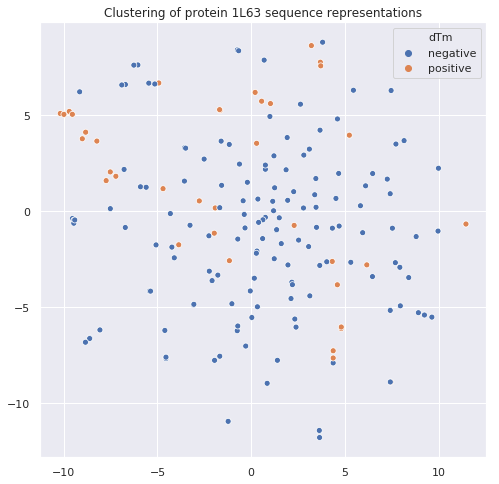

In [0]:
fig, ax = plt.subplots(figsize=(8,8))
sns.scatterplot(x="Feature_01", y="Feature_02", hue="dTm", data=X_embedded_single_df, ax=ax).set_title("Clustering of protein 1L63 sequence representations")
ax.set_ylabel('')    
ax.set_xlabel('')
plt.savefig(fig_loc+"clustering_all_dTm_single_protein.png", dpi=300)
plt.show()